In [1]:
import os
import glob
import email
from email import policy
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import pickle
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kingp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd

df = pd.read_csv("spam_ham_dataset.csv")
df.head()


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
nltk.download('stopwords')

def preprocess(text):
    text = text.lower()

    # Detect URLs, emails
    text = re.sub(r'https?://\S+', ' url ', text)
    text = re.sub(r'www\.\S+', ' url ', text)
    text = re.sub(r'\S+@\S+', ' email ', text)

    # Replace numbers
    text = re.sub(r'\d+', ' num ', text)

    # Replace HTML tags
    text = re.sub(r'<[^>]+>', ' htmltag ', text)

    # Tokenize: keep only words
    words = re.findall(r'\b[a-zA-Z]+\b', text)

    # Remove stopwords + stem
    filtered = [ps.stem(w) for w in words if w not in stopwords.words('english')]

    return " ".join(filtered)

df['clean_text'] = df['text'].apply(preprocess)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,label,text,label_num,clean_text
0,605,0,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter num follow note g...
1,2349,0,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom januari num num see attach fil...
2,3624,0,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho around wonder ti...
3,4685,1,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop window offic cheap main tren...
4,2030,0,Subject: re : indian springs\r\nthis deal is t...,0,subject indian spring deal book teco pvr reven...


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'],
                                                    df['label'],
                                                    test_size=0.2,
                                                    random_state=42)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)


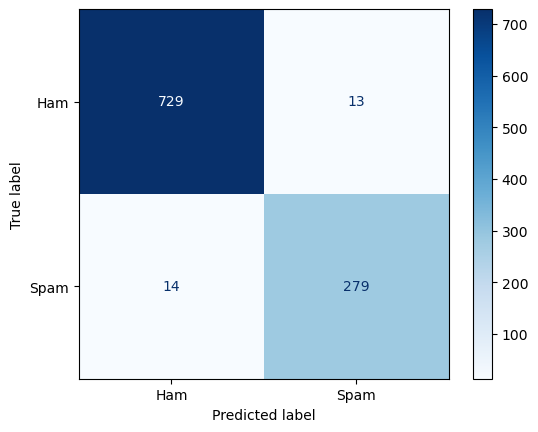

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ham","Spam"])
disp.plot(cmap='Blues')
plt.show()


In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       742
           1       0.96      0.95      0.95       293

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



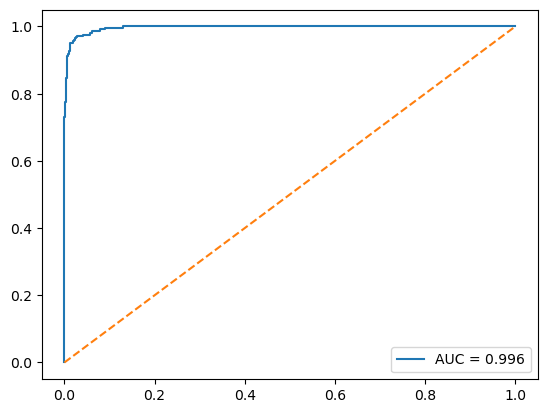

In [9]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()


In [10]:
import pickle

pickle.dump(tfidf, open("vectorizernew.pkl", "wb"))
pickle.dump(model, open("modelnew.pkl", "wb"))
